Data:年收入
Year:2016
Month:2
Area:臺南市
Industry:住
Data:年齡層


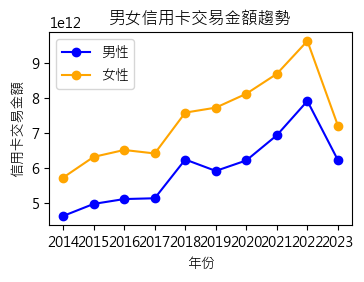

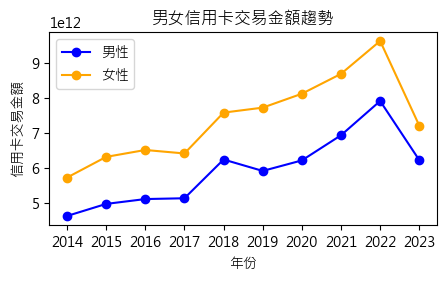

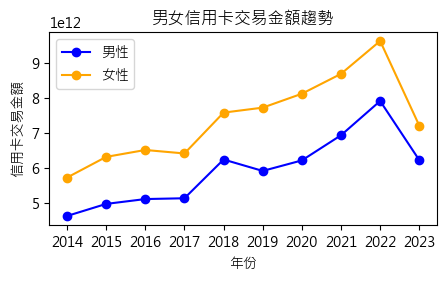

In [112]:
import tkinter as tk
from tkinter import ttk
import pandas as pd
import sqlite3
from tkinter.simpledialog import Dialog
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg


class Window(tk.Tk):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.title("信用卡消費樣態")
        self.conn = sqlite3.connect("creditcard.db")
        plt.rcParams['font.family'] = 'Microsoft JhengHei'

        # -----------interface-----------#
        mainFrame = tk.Frame(self, relief=tk.GROOVE,borderwidth=1)
        tk.Label(
            mainFrame,
            text="信用卡消費樣態",
            font=("arial", 20),
            fg="#333333"
        ).pack(padx=10, pady=10)
        mainFrame.pack(padx=5, pady=10, fill='both')

        # ------搜尋------#
        topFrame = ttk.Labelframe(self, text="搜尋")
        # -------Label------#
        self.dataLabel = ttk.Label(topFrame, text="資料類別:").grid(
            row=0, column=0, padx=(1,0), pady=(20,10), sticky='w'
        )
        self.yearLabel = ttk.Label(topFrame, text="年份:").grid(
            row=1, column=0, padx=(1,0), pady=10, sticky='w'
        )
        self.monthLabel = ttk.Label(topFrame, text="月份:").grid(
            row=2, column=0, padx=(1,0), pady=10, sticky='w'
        )
        self.areaLabel = ttk.Label(topFrame, text="地區:").grid(
            row=3, column=0, padx=(1,0), pady=10, sticky='w'
        )
        self.industryLabel = ttk.Label(topFrame, text="產業別:").grid(
            row=4, column=0, padx=(1,0), pady=(10,30), sticky='w'
        )
        # ------StringVar------#
        self.data_var = tk.StringVar()
        self.data_var.set("請選擇資料類型")
        self.data_mapping = {
            '職業類別':'job', 
            '年收入':'incom',
            '教育程度':'education',
            '兩性':'sex',
            '年齡層':'age'
        }
        self.data = ttk.Combobox(
            topFrame,
            textvariable=self.data_var,
            values=["職業類別", "年收入", "教育程度", "兩性", "年齡層"],
        )
        self.data.grid(row=0, column=1, padx=10, pady=(20,10))
        self.data.bind("<<ComboboxSelected>>", self.load_data)

        self.year_var = tk.StringVar()
        self.year_var.set("請選擇年份")
        self.year = ttk.Combobox(
            topFrame,
            textvariable=self.year_var,
            values=[
                "2014",
                "2015",
                "2016",
                "2017",
                "2018",
                "2019",
                "2020",
                "2021",
                "2022",
                "2023",
            ],
        )
        self.year.grid(row=1, column=1, padx=10, pady=10)
        self.year.bind("<<ComboboxSelected>>", self.load_year)

        self.month_var = tk.StringVar()
        self.month_var.set("請選擇月份")
        self.month = ttk.Combobox(
            topFrame,
            textvariable=self.month_var,
            values=[
                "1",
                "2",
                "3",
                "4",
                "5",
                "6",
                "7",
                "8",
                "9",
                "10",
                "11",
                "12",
                "ALL",
            ],
        )
        self.month.grid(row=2, column=1, padx=10, pady=10)
        self.month.bind("<<ComboboxSelected>>", self.load_month)

        self.area_var = tk.StringVar()
        self.area_var.set("請選擇地區")
        self.area = ttk.Combobox(
            topFrame,
            textvariable=self.area_var,
            values=[
                "臺北市",
                "高雄市",
                "新北市",
                "臺中市",
                "臺南市",
                "桃園市",
                "宜蘭縣",
                "新竹縣",
                "苗栗縣",
                "彰化縣",
                "南投縣",
                "雲林縣",
                "嘉義縣",
                "嘉義市",
                "屏東縣",
                "臺東縣",
                "花蓮縣",
                "澎湖縣",
                "基隆市",
                "新竹市",
                "金門縣",
                "連江縣",
                "ALL",
            ],
        )
        self.area.grid(row=3, column=1, padx=10, pady=10)
        self.area.bind("<<ComboboxSelected>>", self.load_area)

        self.industry_var = tk.StringVar()
        self.industry_var.set("請選擇產業別")
        self.industry = ttk.Combobox(
            topFrame,
            textvariable=self.industry_var,
            values=["食", "衣", "住", "行", "文教康樂", "百貨", "其他", "ALL"],
        )
        self.industry.grid(row=4, column=1, padx=10, pady=10)
        self.industry.bind("<<ComboboxSelected>>", self.load_industry)

        self.botton = tk.Button(topFrame, text='搜尋', state='active', command=self.load_treeview).grid(row=5, column=1)
        topFrame.pack(side=tk.LEFT, padx=(5,5), fill="y")

        # ------------資料呈現------------#
        middleFrame = ttk.Labelframe(self, text="資料")
        self.treeview = ttk.Treeview(middleFrame, show="headings", height=18)
        self.treeview.grid(row=0, column=0, padx=(5,0), pady=10, sticky="ns")

        # -----垂直滾動條------#
        scrollBar = ttk.Scrollbar(
            middleFrame, orient="vertical", command=self.treeview.yview
        )
        scrollBar.grid(row=0, column=1, sticky="ns")  # 使用 grid 進行佈局管理

        self.treeview.configure(yscrollcommand=scrollBar.set)

        middleFrame.pack(padx=(0,10), pady=(0,10), fill='x')

        # ------------分析------------#
        # 連接 SQLite 資料庫
        conn = sqlite3.connect("creditcard.db")

        # 撰寫 SQL 查詢，計算每年男性信用卡金額總數
        sql_male = """
            SELECT 年, SUM(信用卡金額) AS 信用卡交易總金額
            FROM sex
            WHERE 性別 = '男性'
            GROUP BY 年
        """

        sql_female = """
            SELECT 年, SUM(信用卡金額) AS 信用卡交易總金額
            FROM sex
            WHERE 性別 = '女性'
            GROUP BY 年
        """

        sql = """
            SELECT DISTINCT 年
            FROM sex
        """

        # 使用 pandas 的 read_sql_query 方法執行 SQL 查詢，並將結果存入 DataFrame
        df_male = pd.read_sql_query(sql_male, conn)
        df_female = pd.read_sql_query(sql_female, conn)
        df = pd.read_sql_query(sql, conn)

        # 關閉資料庫連接
        conn.close()

        # 創建 ttk.Labelframe
        bottomFrame1 = ttk.Labelframe(self, text="信用卡交易金額趨勢")
        bottomFrame1.pack(side=tk.LEFT,padx=(0,5),pady=(0, 10))

        # 在 Labelframe 中添加 Canvas
        fig, ax = plt.subplots(figsize=(3.9, 2.5))  # 調整寬度和高度的值
        canvas = FigureCanvasTkAgg(fig, master=bottomFrame1)
        canvas_widget = canvas.get_tk_widget()
        canvas_widget.pack(side=tk.TOP, fill=tk.BOTH, expand=1, padx=10, pady=10)

        # 繪製男性折線圖，使用藍色
        ax.plot(df_male['年'], df_male['信用卡交易總金額'], marker='o', label='男性', color='blue')

        # 繪製女性折線圖，使用紅色
        ax.plot(df_female['年'], df_female['信用卡交易總金額'], marker='o', label='女性', color='orange')

        # 加上標題及標籤
        ax.set_title('男女信用卡交易金額趨勢')
        ax.set_xlabel('年份')
        ax.set_ylabel('信用卡交易金額')
        ax.set_xticks(df['年'])

        # 加上圖例
        ax.legend()

        # 顯示圖表
        canvas.draw()
        

        bottomFrame2 = ttk.Labelframe(self, text="男女信用卡交易金額趨勢")
        bottomFrame2.pack(side=tk.LEFT,padx=(0,5),pady=(0, 10))

        # 在 Labelframe 中添加 Canvas
        fig, ax = plt.subplots(figsize=(5, 2.5))  # 調整寬度和高度的值
        canvas = FigureCanvasTkAgg(fig, master=bottomFrame2)
        canvas_widget = canvas.get_tk_widget()
        canvas_widget.pack(side=tk.TOP, fill=tk.BOTH, expand=1, padx=10, pady=10)

        # 繪製男性折線圖，使用藍色
        ax.plot(df_male['年'], df_male['信用卡交易總金額'], marker='o', label='男性', color='blue')

        # 繪製女性折線圖，使用紅色
        ax.plot(df_female['年'], df_female['信用卡交易總金額'], marker='o', label='女性', color='orange')

        # 加上標題及標籤
        ax.set_title('男女信用卡交易金額趨勢')
        ax.set_xlabel('年份')
        ax.set_ylabel('信用卡交易金額')
        ax.set_xticks(df['年'])

        # 加上圖例
        ax.legend()

        # 顯示圖表
        canvas.draw()
        

        bottomFrame3 = ttk.Labelframe(self, text="男女信用卡交易金額趨勢")
        bottomFrame3.pack(side=tk.LEFT,padx=(0,20),pady=(0, 10))

        # 在 Labelframe 中添加 Canvas
        fig, ax = plt.subplots(figsize=(5, 2.5))  # 調整寬度和高度的值
        canvas = FigureCanvasTkAgg(fig, master=bottomFrame3)
        canvas_widget = canvas.get_tk_widget()
        canvas_widget.pack(side=tk.TOP, fill=tk.BOTH, expand=1, padx=10, pady=10)

        # 繪製男性折線圖，使用藍色
        ax.plot(df_male['年'], df_male['信用卡交易總金額'], marker='o', label='男性', color='blue')

        # 繪製女性折線圖，使用紅色
        ax.plot(df_female['年'], df_female['信用卡交易總金額'], marker='o', label='女性', color='orange')

        # 加上標題及標籤
        ax.set_title('男女信用卡交易金額趨勢')
        ax.set_xlabel('年份')
        ax.set_ylabel('信用卡交易金額')
        ax.set_xticks(df['年'])

        # 加上圖例
        ax.legend()

        # 顯示圖表
        canvas.draw()
      

        

        # Bind the event after creating self.treeview
        self.treeview.bind("<ButtonRelease-1>", self.selectedItem)
        self.treeview.bind("<<TreeviewSelect>>", self.selectedItem)

    def load_data(self, event):
        selected_data = self.data_var.get()
        print(f"Data:{selected_data}")
       

    def load_year(self, event):
        selected_year = self.year_var.get()
        print(f"Year:{selected_year}")
        

    def load_month(self, event):
        selected_month = self.month_var.get()
        print(f"Month:{selected_month}")
       

    def load_area(self, event):
        selected_area = self.area_var.get()
        print(f"Area:{selected_area}")
      

    def load_industry(self, event):
        selected_industry = self.industry_var.get()
        print(f"Industry:{selected_industry}")
    

    def load_treeview(self):
        selected_option = self.data_var.get()
        selected_year = self.year_var.get()
        selected_month = self.month_var.get()
        selected_area = self.area_var.get()
        selected_industry = self.industry_var.get()
        table = self.data_mapping.get(selected_option)

        if table and selected_option and selected_year:
            sql = f"SELECT * FROM {table} WHERE 年 = '{selected_year}'"

            if (
                selected_month
                and selected_month != "請選擇月份"
                and selected_month != "ALL"
            ):
                sql += f" AND 月 = '{selected_month}'"

            if (
                selected_area
                and selected_area != "請選擇地區"
                and selected_area != "ALL"
            ):
                sql += f" AND 地區 = '{selected_area}'"

            if (
                selected_industry
                and selected_industry != "請選擇產業別"
                and selected_industry != "ALL"
            ):
                sql += f" AND 產業別 = '{selected_industry}'"

            data = pd.read_sql_query(sql, self.conn)
            self.display_data(data)

    def selectedItem(self, event):
        selected_item = self.treeview.focus()
        data_dict = self.treeview.item(selected_item)
        data_list = data_dict["values"]
        if data_list:
            index = self.treeview.index(selected_item)
            # 將欄位名稱和資料一起傳遞給 ShowDetail
            ShowDetail(self, self.treeview["columns"], data_list, title="資訊")

    def display_data(self, data):
        self.treeview.delete(*self.treeview.get_children())  # 清空 Treeview

        if not data.empty:
            columns = list(data.columns)
            self.treeview["columns"] = columns
            for col in columns:
                self.treeview.heading(col, text=col, anchor="w")
                self.treeview.column(col, anchor="w", width=100)  # 設定欄位寬度，可以自行調整

            for index, row in data.iterrows():
                values = [row[col] for col in columns]
                self.treeview.insert("", "end", values=values)
            


class ShowDetail(Dialog):
    def __init__(self, parent, columns, data, **kwargs):
        self.columns = columns
        self.data = data
        super().__init__(parent, **kwargs)

    def body(self, master):
        self.GetDataInfo_var = tk.StringVar()
        mainFrame = tk.Label(
            master, textvariable=self.GetDataInfo_var, padx=10, pady=10
        )

        try:
            for col, value in zip(self.columns, self.data):
                dataInfo = tk.Label(master, text=f"{col}:  {value}")
                dataInfo.pack(pady=1, anchor="nw")
        except Exception as e:
            print(f"Exception in ShowDetail: {e}")
            print("Columns:", self.columns)
            print("Data:", self.data)

    def buttonbox(self):
        box = tk.Frame(self)
        w = tk.Button(box, text="確認", width=10, command=self.ok, default="active")
        w.pack(padx=5, pady=(5, 20))
        self.bind("<Return>", self.ok)

        box.pack()


def main():
    window = Window()
    window.resizable(width=False, height=False)
    window.mainloop()


if __name__ == "__main__":
    main()

Data:兩性
Data:年收入
Data:年齡層


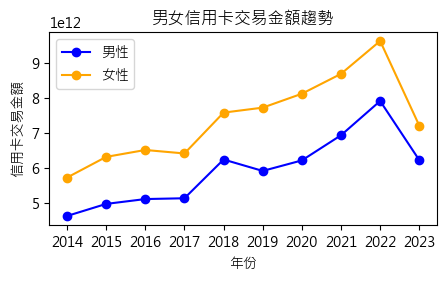

In [110]:
import tkinter as tk
from tkinter import ttk
import pandas as pd
import sqlite3
from tkinter.simpledialog import Dialog
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg


class Window(tk.Tk):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.title("信用卡消費樣態")
        self.conn = sqlite3.connect("creditcard.db")
        plt.rcParams['font.family'] = 'Microsoft JhengHei'

        # -----------interface-----------#
        mainFrame = tk.Frame(self, relief=tk.GROOVE, borderwidth=1)
        tk.Label(
            mainFrame,
            text="信用卡消費樣態",
            font=("arial", 20),
            fg="#333333"
        ).pack(padx=10, pady=10)
        mainFrame.pack(padx=5, pady=10, fill='both')

        # ------搜尋------#
        topFrame = ttk.Labelframe(self, text="搜尋")
        # -------Label------#
        self.dataLabel = ttk.Label(topFrame, text="資料類別:").grid(
            row=0, column=0, padx=(1, 0), pady=(20, 10), sticky='w'
        )
        self.yearLabel = ttk.Label(topFrame, text="年份:").grid(
            row=1, column=0, padx=(1, 0), pady=10, sticky='w'
        )
        self.monthLabel = ttk.Label(topFrame, text="月份:").grid(
            row=2, column=0, padx=(1, 0), pady=10, sticky='w'
        )
        self.areaLabel = ttk.Label(topFrame, text="地區:").grid(
            row=3, column=0, padx=(1, 0), pady=10, sticky='w'
        )
        self.industryLabel = ttk.Label(topFrame, text="產業別:").grid(
            row=4, column=0, padx=(1, 0), pady=(10, 30), sticky='w'
        )
        # ------StringVar------#
        self.data_var = tk.StringVar()
        self.data_var.set("請選擇資料類型")
        self.data_mapping = {
            '職業類別': 'job',
            '年收入': 'incom',
            '教育程度': 'education',
            '兩性': 'sex',
            '年齡層': 'age'
        }
        self.data = ttk.Combobox(
            topFrame,
            textvariable=self.data_var,
            values=["職業類別", "年收入", "教育程度", "兩性", "年齡層"],
        )
        self.data.grid(row=0, column=1, padx=10, pady=(20, 10))
        self.data.bind("<<ComboboxSelected>>", self.load_data)

        self.year_var = tk.StringVar()
        self.year_var.set("請選擇年份")
        self.year = ttk.Combobox(
            topFrame,
            textvariable=self.year_var,
            values=[
                "2014",
                "2015",
                "2016",
                "2017",
                "2018",
                "2019",
                "2020",
                "2021",
                "2022",
                "2023",
            ],
        )
        self.year.grid(row=1, column=1, padx=10, pady=10)
        self.year.bind("<<ComboboxSelected>>", self.load_year)

        self.month_var = tk.StringVar()
        self.month_var.set("請選擇月份")
        self.month = ttk.Combobox(
            topFrame,
            textvariable=self.month_var,
            values=[
                "1",
                "2",
                "3",
                "4",
                "5",
                "6",
                "7",
                "8",
                "9",
                "10",
                "11",
                "12",
                "ALL",
            ],
        )
        self.month.grid(row=2, column=1, padx=10, pady=10)
        self.month.bind("<<ComboboxSelected>>", self.load_month)

        self.area_var = tk.StringVar()
        self.area_var.set("請選擇地區")
        self.area = ttk.Combobox(
            topFrame,
            textvariable=self.area_var,
            values=[
                "臺北市",
                "高雄市",
                "新北市",
                "臺中市",
                "臺南市",
                "桃園市",
                "宜蘭縣",
                "新竹縣",
                "苗栗縣",
                "彰化縣",
                "南投縣",
                "雲林縣",
                "嘉義縣",
                "嘉義市",
                "屏東縣",
                "臺東縣",
                "花蓮縣",
                "澎湖縣",
                "基隆市",
                "新竹市",
                "金門縣",
                "連江縣",
                "ALL",
            ],
        )
        self.area.grid(row=3, column=1, padx=10, pady=10)
        self.area.bind("<<ComboboxSelected>>", self.load_area)

        self.industry_var = tk.StringVar()
        self.industry_var.set("請選擇產業別")
        self.industry = ttk.Combobox(
            topFrame,
            textvariable=self.industry_var,
            values=["食", "衣", "住", "行", "文教康樂", "百貨", "其他", "ALL"],
        )
        self.industry.grid(row=4, column=1, padx=10, pady=(10, 30))
        self.industry.bind("<<ComboboxSelected>>", self.load_industry)

        topFrame.pack(side=tk.LEFT, padx=(5, 5), fill="y")

        # ------------資料呈現------------#
        middleFrame = ttk.Labelframe(self, text="資料")
        self.treeview = ttk.Treeview(middleFrame, show="headings", height=18)
        self.treeview.grid(row=0, column=0, padx=(5, 0), pady=10, sticky="ns")

        # -----垂直滾動條------#
        scrollBar = ttk.Scrollbar(
            middleFrame, orient="vertical", command=self.treeview.yview
        )
        scrollBar.grid(row=0, column=1, sticky="ns")  # 使用 grid 進行佈局管理

        self.treeview.configure(yscrollcommand=scrollBar.set)

        middleFrame.pack(padx=(0, 10), pady=(0, 10), fill='x')

        # ------------分析------------#
        self.bottomFrame = ttk.Labelframe(self, text="男女信用卡交易金額趨勢")
        self.bottomFrame.pack(side=tk.LEFT, padx=(0, 5), pady=(0, 10))

        # 連接 SQLite 資料庫
        conn = sqlite3.connect("creditcard.db")

        # 撰寫 SQL 查詢，計算每年男性信用卡金額總數
        sql_male = """
            SELECT 年, SUM(信用卡金額) AS 信用卡交易總金額
            FROM sex
            WHERE 性別 = '男性'
            GROUP BY 年
        """

        sql_female = """
            SELECT 年, SUM(信用卡金額) AS 信用卡交易總金額
            FROM sex
            WHERE 性別 = '女性'
            GROUP BY 年
        """

        sql = """
            SELECT DISTINCT 年
            FROM sex
        """

        # 使用 pandas 的 read_sql_query 方法執行 SQL 查詢，並將結果存入 DataFrame
        df_male = pd.read_sql_query(sql_male, conn)
        df_female = pd.read_sql_query(sql_female, conn)
        df = pd.read_sql_query(sql, conn)

        # 關閉資料庫連接
        conn.close()

        # 在 Labelframe 中添加 Canvas
        self.fig, self.ax = plt.subplots(figsize=(5, 2.5))  # 調整寬度和高度的值
        self.canvas = FigureCanvasTkAgg(self.fig, master=self.bottomFrame)
        canvas_widget = self.canvas.get_tk_widget()
        canvas_widget.pack(side=tk.TOP, fill=tk.BOTH, expand=1, padx=10, pady=10)

        # 繪製男性折線圖，使用藍色
        self.ax.plot(df_male['年'], df_male['信用卡交易總金額'], marker='o', label='男性', color='blue')

        # 繪製女性折線圖，使用紅色
        self.ax.plot(df_female['年'], df_female['信用卡交易總金額'], marker='o', label='女性', color='orange')

        # 加上標題及標籤
        self.ax.set_title('男女信用卡交易金額趨勢')
        self.ax.set_xlabel('年份')
        self.ax.set_ylabel('信用卡交易金額')
        self.ax.set_xticks(df['年'])

        # 加上圖例
        self.ax.legend()

        # 隱藏圖表
        self.canvas.draw()
        self.bottomFrame.pack_forget()

        # Bind the event after creating self.treeview
        self.treeview.bind("<ButtonRelease-1>", self.selectedItem)
        self.treeview.bind("<<TreeviewSelect>>", self.selectedItem)

    def load_data(self, event):
        selected_data = self.data_var.get()
        print(f"Data:{selected_data}")
        if selected_data == '兩性':
            self.bottomFrame.pack(side=tk.LEFT, padx=(0, 5), pady=(0, 10))
        else:
            self.bottomFrame.pack_forget()
        self.load_treeview()

    def load_year(self, event):
        selected_year = self.year_var.get()
        print(f"Year:{selected_year}")
        self.load_treeview()

    def load_month(self, event):
        selected_month = self.month_var.get()
        print(f"Month:{selected_month}")
        self.load_treeview()

    def load_area(self, event):
        selected_area = self.area_var.get()
        print(f"Area:{selected_area}")
        self.load_treeview()

    def load_industry(self, event):
        selected_industry = self.industry_var.get()
        print(f"Industry:{selected_industry}")
        self.load_treeview()

    def load_treeview(self):
        selected_option = self.data_var.get()
        selected_year = self.year_var.get()
        selected_month = self.month_var.get()
        selected_area = self.area_var.get()
        selected_industry = self.industry_var.get()
        table = self.data_mapping.get(selected_option)

        if table and selected_option and selected_year:
            sql = f"SELECT * FROM {table} WHERE 年 = '{selected_year}'"

            if (
                    selected_month
                    and selected_month != "請選擇月份"
                    and selected_month != "ALL"
            ):
                sql += f" AND 月 = '{selected_month}'"

            if (
                    selected_area
                    and selected_area != "請選擇地區"
                    and selected_area != "ALL"
            ):
                sql += f" AND 地區 = '{selected_area}'"

            if (
                    selected_industry
                    and selected_industry != "請選擇產業別"
                    and selected_industry != "ALL"
            ):
                sql += f" AND 產業別 = '{selected_industry}'"

            data = pd.read_sql_query(sql, self.conn)
            self.display_data(data)

    def selectedItem(self, event):
        selected_item = self.treeview.focus()
        data_dict = self.treeview.item(selected_item)
        data_list = data_dict["values"]
        if data_list:
            index = self.treeview.index(selected_item)
            # 將欄位名稱和資料一起傳遞給 ShowDetail
            ShowDetail(self, self.treeview["columns"], data_list, title="資訊")

    def display_data(self, data):
        self.treeview.delete(*self.treeview.get_children())  # 清空 Treeview

        if not data.empty:
            columns = list(data.columns)
            self.treeview["columns"] = columns
            for col in columns:
                self.treeview.heading(col, text=col, anchor="w")
                self.treeview.column(col, anchor="w", width=100)  # 設定欄位寬度，可以自行調整

            for index, row in data.iterrows():
                values = [row[col] for col in columns]
                self.treeview.insert("", "end", values=values)

    
            





def main():
    window = Window()

    window.mainloop()


if __name__ == "__main__":
    main()

In [109]:
import tkinter as tk
from tkinter import ttk
import pandas as pd
import sqlite3
from tkinter.simpledialog import Dialog
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg


class Window(tk.Tk):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.title("信用卡消費樣態")
        self.conn = sqlite3.connect("creditcard.db")
        plt.rcParams['font.family'] = 'Microsoft JhengHei'

        # -----------interface-----------#
        mainFrame = tk.Frame(self, relief=tk.GROOVE,borderwidth=1)
        tk.Label(
            mainFrame,
            text="信用卡消費樣態",
            font=("arial", 20),
            fg="#333333"
        ).pack(padx=10, pady=10)
        mainFrame.pack(padx=5, pady=10, fill='both')

        # ------搜尋------#
        topFrame = ttk.Labelframe(self, text="搜尋")
        # -------Label------#
        self.dataLabel = ttk.Label(topFrame, text="資料類別:").grid(
            row=0, column=0, padx=(1,0), pady=(20,10), sticky='w'
        )
        self.yearLabel = ttk.Label(topFrame, text="年份:").grid(
            row=1, column=0, padx=(1,0), pady=10, sticky='w'
        )
        self.monthLabel = ttk.Label(topFrame, text="月份:").grid(
            row=2, column=0, padx=(1,0), pady=10, sticky='w'
        )
        self.areaLabel = ttk.Label(topFrame, text="地區:").grid(
            row=3, column=0, padx=(1,0), pady=10, sticky='w'
        )
        self.industryLabel = ttk.Label(topFrame, text="產業別:").grid(
            row=4, column=0, padx=(1,0), pady=(10,30), sticky='w'
        )
        # ------StringVar------#
        self.data_var = tk.StringVar()
        self.data_var.set("請選擇資料類型")
        self.data_mapping = {
            '職業類別':'job', 
            '年收入':'incom',
            '教育程度':'education',
            '兩性':'sex',
            '年齡層':'age'
        }
        self.data = ttk.Combobox(
            topFrame,
            textvariable=self.data_var,
            values=["職業類別", "年收入", "教育程度", "兩性", "年齡層"],
        )
        self.data.grid(row=0, column=1, padx=10, pady=(20,10))
        self.data.bind("<<ComboboxSelected>>", self.load_data)

        self.year_var = tk.StringVar()
        self.year_var.set("請選擇年份")
        self.year = ttk.Combobox(
            topFrame,
            textvariable=self.year_var,
            values=[
                "2014",
                "2015",
                "2016",
                "2017",
                "2018",
                "2019",
                "2020",
                "2021",
                "2022",
                "2023",
            ],
        )
        self.year.grid(row=1, column=1, padx=10, pady=10)
        self.year.bind("<<ComboboxSelected>>", self.load_year)

        self.month_var = tk.StringVar()
        self.month_var.set("請選擇月份")
        self.month = ttk.Combobox(
            topFrame,
            textvariable=self.month_var,
            values=[
                "1",
                "2",
                "3",
                "4",
                "5",
                "6",
                "7",
                "8",
                "9",
                "10",
                "11",
                "12",
                "ALL",
            ],
        )
        self.month.grid(row=2, column=1, padx=10, pady=10)
        self.month.bind("<<ComboboxSelected>>", self.load_month)

        self.area_var = tk.StringVar()
        self.area_var.set("請選擇地區")
        self.area = ttk.Combobox(
            topFrame,
            textvariable=self.area_var,
            values=[
                "臺北市",
                "高雄市",
                "新北市",
                "臺中市",
                "臺南市",
                "桃園市",
                "宜蘭縣",
                "新竹縣",
                "苗栗縣",
                "彰化縣",
                "南投縣",
                "雲林縣",
                "嘉義縣",
                "嘉義市",
                "屏東縣",
                "臺東縣",
                "花蓮縣",
                "澎湖縣",
                "基隆市",
                "新竹市",
                "金門縣",
                "連江縣",
                "ALL",
            ],
        )
        self.area.grid(row=3, column=1, padx=10, pady=10)
        self.area.bind("<<ComboboxSelected>>", self.load_area)

        self.industry_var = tk.StringVar()
        self.industry_var.set("請選擇產業別")
        self.industry = ttk.Combobox(
            topFrame,
            textvariable=self.industry_var,
            values=["食", "衣", "住", "行", "文教康樂", "百貨", "其他", "ALL"],
        )
        self.industry.grid(row=4, column=1, padx=10, pady=(10,30))
        self.industry.bind("<<ComboboxSelected>>", self.load_industry)

        topFrame.pack(side=tk.LEFT, padx=(5,5), fill="y")

        # ------------資料呈現------------#
        middleFrame = ttk.Labelframe(self, text="資料")
        self.treeview = ttk.Treeview(middleFrame, show="headings", height=18)
        self.treeview.grid(row=0, column=0, padx=(5,0), pady=10, sticky="ns")

        # -----垂直滾動條------#
        scrollBar = ttk.Scrollbar(
            middleFrame, orient="vertical", command=self.treeview.yview
        )
        scrollBar.grid(row=0, column=1, sticky="ns")  # 使用 grid 進行佈局管理

        self.treeview.configure(yscrollcommand=scrollBar.set)

        middleFrame.pack(padx=(0,10), pady=(0,10), fill='x')

        # ------------分析------------#

        

        #------Bind------#
        self.treeview.bind("<ButtonRelease-1>", self.selectedItem)
        self.treeview.bind("<<TreeviewSelect>>", self.selectedItem)

    def load_data(self, event):
        selected_data = self.data_var.get()
        print(f"Data:{selected_data}")
        self.load_treeview()

    def load_year(self, event):
        selected_year = self.year_var.get()
        print(f"Year:{selected_year}")
        self.load_treeview()

    def load_month(self, event):
        selected_month = self.month_var.get()
        print(f"Month:{selected_month}")
        self.load_treeview()

    def load_area(self, event):
        selected_area = self.area_var.get()
        print(f"Area:{selected_area}")
        self.load_treeview()

    def load_industry(self, event):
        selected_industry = self.industry_var.get()
        print(f"Industry:{selected_industry}")
        self.load_treeview()

    def load_treeview(self):
        selected_option = self.data_var.get()
        selected_year = self.year_var.get()
        selected_month = self.month_var.get()
        selected_area = self.area_var.get()
        selected_industry = self.industry_var.get()
        table = self.data_mapping.get(selected_option)

        if table and selected_option and selected_year:
            sql = f"SELECT * FROM {table} WHERE 年 = '{selected_year}'"

            if (
                selected_month
                and selected_month != "請選擇月份"
                and selected_month != "ALL"
            ):
                sql += f" AND 月 = '{selected_month}'"

            if (
                selected_area
                and selected_area != "請選擇地區"
                and selected_area != "ALL"
            ):
                sql += f" AND 地區 = '{selected_area}'"

            if (
                selected_industry
                and selected_industry != "請選擇產業別"
                and selected_industry != "ALL"
            ):
                sql += f" AND 產業別 = '{selected_industry}'"

            data = pd.read_sql_query(sql, self.conn)
            self.display_data(data)

    def selectedItem(self, event):
        selected_item = self.treeview.focus()
        data_dict = self.treeview.item(selected_item)
        data_list = data_dict["values"]
        if data_list:
            index = self.treeview.index(selected_item)
            # 將欄位名稱和資料一起傳遞給 ShowDetail
            ShowDetail(self, self.treeview["columns"], data_list, title="資訊")

    def display_data(self, data):
        self.treeview.delete(*self.treeview.get_children())  # 清空 Treeview

        if not data.empty:
            columns = list(data.columns)
            self.treeview["columns"] = columns
            for col in columns:
                self.treeview.heading(col, text=col, anchor="w")
                self.treeview.column(col, anchor="w", width=100)  # 設定欄位寬度，可以自行調整

            for index, row in data.iterrows():
                values = [row[col] for col in columns]
                self.treeview.insert("", "end", values=values)
            


class ShowDetail(Dialog):
    def __init__(self, parent, columns, data, **kwargs):
        self.columns = columns
        self.data = data
        super().__init__(parent, **kwargs)

    def body(self, master):
        self.GetDataInfo_var = tk.StringVar()
        mainFrame = tk.Label(
            master, textvariable=self.GetDataInfo_var, padx=10, pady=10
        )

        try:
            for col, value in zip(self.columns, self.data):
                dataInfo = tk.Label(master, text=f"{col}:  {value}")
                dataInfo.pack(pady=1, anchor="nw")
        except Exception as e:
            print(f"Exception in ShowDetail: {e}")
            print("Columns:", self.columns)
            print("Data:", self.data)

    def buttonbox(self):
        box = tk.Frame(self)
        w = tk.Button(box, text="確認", width=10, command=self.ok, default="active")
        w.pack(padx=5, pady=(5, 20))
        self.bind("<Return>", self.ok)

        box.pack()


def main():
    window = Window()
    window.resizable(width=False, height=False)
    window.mainloop()


if __name__ == "__main__":
    main()

Data:年收入
Year:2016
Data:兩性
